In [57]:
from pathlib import Path
from topopt.monitoring import MetricTracker
import pandas as pd
import re

In [58]:
OUTPUTS_DIR = Path("../outputs")

metrics_by_run = {}

for run_dir in OUTPUTS_DIR.iterdir():
    if not run_dir.is_dir():
        continue

    metrics_path = run_dir / "metrics_log.npz"
    if not metrics_path.exists():
        continue

    name = run_dir.name
    if "neural_field" not in name:
        continue

    key = name.split("neural_field", 1)[1]
    key = key.lstrip("_-")

    # Load metrics
    metrics = MetricTracker.load(npz_path=metrics_path)

    metrics_by_run[key] = metrics

In [59]:
print(metrics_by_run.keys())

dict_keys(['train_siren_omega_17_scale_2', 'train_siren_omega_35_scale_1', 'train_siren_omega_35_scale_2', 'train_siren_omega_20_scale_1', 'train_siren_omega_20_scale_2', 'train_siren_omega_8_scale_2', 'train_siren_omega_5_scale_1', 'train_siren_omega_17_scale_1', 'train_siren_omega_11_scale_2', 'train_siren_omega_14_scale_2', 'train_siren_omega_25_scale_2', 'train_siren_omega_5_scale_2', 'train_siren_omega_30_scale_1', 'train_siren_omega_14_scale_1', 'train_siren_omega_8_scale_1', 'train_siren_omega_25_scale_1', 'train_siren_omega_30_scale_2', 'train_siren_omega_11_scale_1'])


In [60]:
OUTPUTS_DIR = Path("../outputs")

def parse(path: Path) -> pd.DataFrame:
    return pd.read_csv(
        path,
        sep=r"\s+",
        index_col=0
    )


# ----------------------------------------
# Main aggregation
# ----------------------------------------

eval_results_by_run = {}

for run_dir in OUTPUTS_DIR.iterdir():
    if not run_dir.is_dir():
        continue

    log_path = run_dir / "evaluate.log"
    if not log_path.exists():
        continue

    if "neural_field" not in run_dir.name:
        continue

    # Key: everything after "neural_field"
    key = run_dir.name.split("neural_field", 1)[1].lstrip("_-")

    try:
        df = parse(log_path)
    except Exception as e:
        print(f"[WARN] Failed to parse {log_path}: {e}")
        continue
    eval_results_by_run[key] = df

In [61]:
cols_to_drop = ["rho_actual", "rho_target", "rho_error", "penalty"]

for key, df in eval_results_by_run.items():
    # extract scale from key, e.g. "train_siren_omega_17_scale_2"
    match = re.search(r"scale_(\d+)", key)
    scale = int(match.group(1)) if match else None

    # add scale column
    df["scale"] = scale

    # drop unwanted columns (ignore in case some are missing)
    df.drop(columns=cols_to_drop, inplace=True, errors="ignore")

    print(key)
    print(df)

train_siren_omega_17_scale_2
         compliance  omega  scale
model_0     77.5269   17.0      2
model_7     78.1816   17.0      2
model_4     78.8648   17.0      2
model_6     79.4034   17.0      2
model_1     79.4777   17.0      2
model_3     80.1858   17.0      2
model_5     80.4601   17.0      2
model_2     87.8923   17.0      2
train_siren_omega_35_scale_1
         compliance  omega  scale
model_5     81.5080   35.0      1
model_7     83.6627   35.0      1
model_4     84.0277   35.0      1
model_3     85.9186   35.0      1
model_1     89.4213   35.0      1
model_2     93.9669   35.0      1
model_6     94.4890   35.0      1
model_0     96.2373   35.0      1
train_siren_omega_35_scale_2
         compliance  omega  scale
model_5     77.2290   35.0      2
model_7     77.2996   35.0      2
model_0     85.7911   35.0      2
model_3     87.1008   35.0      2
model_4     87.3730   35.0      2
model_6     90.5478   35.0      2
model_1     91.0810   35.0      2
model_2     95.7763   35.0   

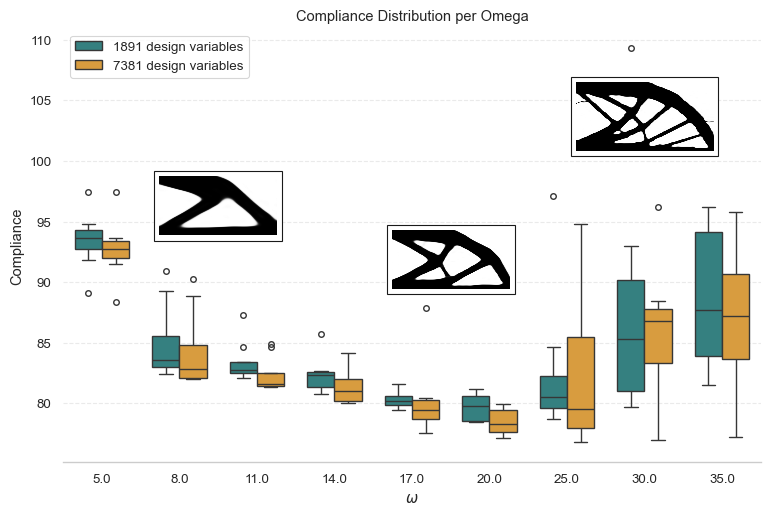

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------------------------------
# Data (as you already have it)
# --------------------------------------------------
all_dfs = [df.copy() for df in eval_results_by_run.values()]
data = pd.concat(all_dfs, axis=0)

data["omega"] = pd.Categorical(
    data["omega"],
    categories=sorted(data["omega"].unique()),
    ordered=True
)

# --------------------------------------------------
# Seaborn style
# --------------------------------------------------
sns.set_theme(style="whitegrid", context="paper", font_scale=1.1)

# --------------------------------------------------
# Figure layout
# --------------------------------------------------
fig = plt.figure(figsize=(9, 9))
gs = fig.add_gridspec(2, 3, height_ratios=[2.2, 1])

# --------------------------------------------------
# (a) Boxplot
# --------------------------------------------------
ax_main = fig.add_subplot(gs[0, :])

palette = {
    1: "#298c8c",
    2: "#f1a226",
}

sns.boxplot(
    data=data,
    x="omega",
    y="compliance",
    hue="scale",
    palette=palette,
    width=0.7,
    dodge=True,
    fliersize=4,
    linewidth=1,
    ax=ax_main
)

ax_main.set_xlabel(r"$\omega$")
ax_main.set_ylabel("Compliance")
ax_main.set_title("Compliance Distribution per Omega")

handles, labels = ax_main.get_legend_handles_labels()
labels = ["1891 design variables", "7381 design variables"]
ax_main.legend(handles, labels, frameon=True)

ax_main.grid(axis="y", linestyle="--", alpha=0.4)
sns.despine(ax=ax_main, left=True)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox


image_paths = {
    11:  "./omega_11.png",
    20: "./omega_20.png",
    35: "./omega_35.png",
}

y_top = ax_main.get_ylim()[1]

img = plt.imread(image_paths[11])
imagebox = OffsetImage(img, zoom=0.03)

x_pos = 1.5
y_pos = y_top * 0.89

ab = AnnotationBbox(
    imagebox,
    (x_pos, y_pos),
    frameon=True,
    box_alignment=(0.5, 1.0)
)

ax_main.add_artist(ab)


y_top = ax_main.get_ylim()[1]

img = plt.imread(image_paths[20])
imagebox = OffsetImage(img, zoom=0.03)

x_pos = 4.5
y_pos = y_top * 0.85

ab = AnnotationBbox(
    imagebox,
    (x_pos, y_pos),
    frameon=True,
    box_alignment=(0.5, 1.0)
)

ax_main.add_artist(ab)


y_top = ax_main.get_ylim()[1]

img = plt.imread(image_paths[35])
imagebox = OffsetImage(img, zoom=0.035)

x_pos = 7
y_pos = y_top * 0.96

ab = AnnotationBbox(
    imagebox,
    (x_pos, y_pos),
    frameon=True,
    box_alignment=(0.5, 1.0)
)

ax_main.add_artist(ab)
plt.savefig(
    "compliance_vs_omega.pdf",
    bbox_inches="tight"
)